<a href="https://colab.research.google.com/github/Chiwidude/ETL-EstimadorRiesgo/blob/dscience/ETLv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Preparación de Entorno**

In [ ]:
#ejecutar sino se tienen instaladas estas librerías
!pip install -U scikit-learn
!pip install scikit-learn-intelex
!pip install -U imbalanced-learn
!pip install xgboost
!pip install seaborn
!pip install Pyspatialml
!pip install scikit-learn-intelex
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 5.3 MB/s 
     |████████████████████████████████| 26.0 MB 72.4 MB/s 
     |████████████████████████████████| 300.3 MB 20 kB/s 
     |████████████████████████████████| 4.0 MB 45.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 199 kB 39.7 MB/s 
     |████████████████████████████████| 199 kB 71.9 MB/s 
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.8.1
    Uninstalling imbalanced-learn-0.8.1:
      Successfully uninstalled imbalanced-learn-0.8.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pk

In [ ]:
from pyspatialml import Raster
import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.plot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Conjuntos de datos variables independientes

In [ ]:
lsd_df = gpd.read_file("drive/MyDrive/Tesis/deslizamientos/desli_lim.shp")

files = ["drive/MyDrive/Tesis/raster_curvatura/curvatura_r.tif","drive/MyDrive/Tesis/raster_elevacion/elevacion_r.tif","drive/MyDrive/Tesis/raster_pendiente/pendiente_r.tif","drive/MyDrive/Tesis/raster_perfil_curvatura/perfilc_r.tif",
         "drive/MyDrive/Tesis/raster_lluvia/lluvia_r.tif","drive/MyDrive/Tesis/raster_cobertura/cobertura_r.tif"]
rasters =Raster(files)

In [ ]:
raster_desli = rasterio.open('drive/MyDrive/Tesis/deslizamientos/raster/desli_lim.tif')

In [ ]:
rasters.bounds

BoundingBox(left=323388.7577661315, bottom=1589357.1699691617, right=508688.7577661315, top=1777837.1699691617)

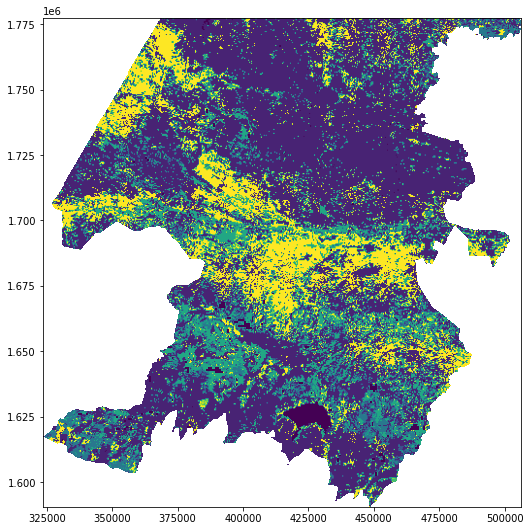

In [ ]:
fig, ax = plt.subplots(figsize=(9, 9))

rasters.cobertura_r.plot(ax=ax)
rasterio.plot.show(raster_desli, ax=ax)
plt.show()

In [ ]:
extracted_df = rasters.extract_raster(raster_desli)

extracted_df.dropna(inplace=True)
extracted_df

,value,curvatura_r,elevacion_r,pendiente_r,perfilc_r,lluvia_r,cobertura_r,geometry
0,0.0,0.50,1621.0,9.800000,0.473218,2392.033447,2.0,POINT (369009.824 1777200.007)
1,0.0,0.75,1574.0,20.196274,0.687335,2648.619141,2.0,POINT (373376.451 1777200.007)
2,0.0,1.00,1640.0,2.977056,1.483140,2869.323730,2.0,POINT (378470.851 1777200.007)
3,0.0,0.75,594.0,21.701746,-3.096038,2679.779541,2.0,POINT (404670.618 1777200.007)
4,0.0,0.25,391.0,22.294275,0.006878,2923.886230,2.0,POINT (417770.501 1777200.007)
...,...,...,...,...,...,...,...,...
6159,0.0,1.25,894.0,11.518590,-0.665087,2843.120117,7.0,POINT (451247.982 1594529.407)
6160,0.0,0.50,820.0,1.662445,-0.142286,3109.098877,7.0,POINT (449792.439 1593801.636)
6162,0.0,0.25,767.0,6.109069,0.095966,3204.624512,2.0,POINT (449064.668 1593073.865)
6163,0.0,0.50,779.0,2.679327,0.239556,3208.293701,7.0,POINT (449792.439 1593073.865)


# Pipeline Ciencia de Datos (ML)

In [ ]:
#Data Spliting inicial
from sklearnex import patch_sklearn 
patch_sklearn()
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV,cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Random Forest

In [ ]:
X = extracted_df.drop(columns=['value','geometry']).values

Y = extracted_df['value'].values

smote = SVMSMOTE(random_state=30, n_jobs=-1)

X_smote, Y_smote = smote.fit_resample(X,Y)

x_train, x_test, y_train, y_test = train_test_split(X_smote,Y_smote,test_size=0.2, random_state=30)

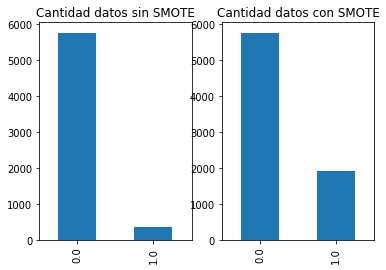

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2,constrained_layout = True)
pd.Series(Y).value_counts().plot(kind='bar', ax=axes[0])
pd.Series(Y_smote).value_counts().plot(kind='bar', ax=axes[1])

axes[0].set_title('Cantidad datos sin SMOTE')
axes[1].set_title('Cantidad datos con SMOTE')
plt.show()

In [ ]:
#Búsqueda mejor ajuste hiperparámetros
base_classifier = RandomForestClassifier()

n_estimators = [100,250,500,750,1000,1200]

max_depth = [50,100, 250, 350, 500]

min_samples_split = [5, 10, 15, 20, 30]

min_samples_leaf = [2,4,6,10]

max_leaf_nodes= [20, 50, 100,150,200]



params_grid = {'n_estimators':n_estimators,
               'max_depth':max_depth,
               'min_samples_split':min_samples_split,
               'min_samples_leaf':min_samples_leaf,
              'max_leaf_nodes':max_leaf_nodes}

rf_sampled = GridSearchCV(estimator=base_classifier,
                                param_grid=params_grid,
                                cv=5, verbose=2, n_jobs = -1,
                                return_train_score=True,
                          scoring=['f1','precision','accuracy','recall'],
                          refit='f1'                 
                                )

rf_sampled.fit(x_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-pac

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 5, 10, 20, 50, 100,
                                                      None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [1, 2, 5, 10, 15,
                                                              20, 30],
                                        'n_estimators': array([ 100,  307,  514,  721,  928, 1135, 1342, 1550, 1757, 1964, 2171,
       2378, 2585, 2792, 3000])},
                   random_state=42, verbose=2)

In [ ]:
params = rf_sampled.best_params_

params['n_jobs'] = -1

params

{'n_estimators': 1757,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': None,
 'criterion': 'entropy'}

### Hiperparámetros ajustados


In [ ]:
classifier = RandomForestClassifier(**params)

rf = Pipeline(
    [('scaling', StandardScaler()),
        ('classifier', classifier)])

rf.fit(x_train, y_train)

In [ ]:
result_rf = rasters.predict(estimator=rf, progress=True)

result_probs = rasters.predict_proba(estimator=rf, progress=True)

0.8843373239138712

In [ ]:
fig, ax = plt.subplots(figsize=(9, 9))

result_rf.iloc[0].cmap = "Dark2"
result_rf.iloc[0].categorical = True
result_rf.iloc[0].plot(ax=ax, legend=True, categorical=True)
plt.show()

Pipeline(steps=[('scaling', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(criterion='entropy',
                                        max_features='log2',
                                        n_estimators=1757))])

In [ ]:
y_pred_ajustado = rf.predict(x_test)

y_ajustado_proba = rf.predict_proba(x_test)[::,1]

In [ ]:
result_rf = rasters.predict(estimator=rf)

result_probs = rasters.predict_proba(estimator=rf)

### Hiperparámetros default


In [ ]:
b_classifier = RandomForestClassifier(n_jobs=-1)

brf = Pipeline([('scaling', StandardScaler()),
        ('classifier', b_classifier)])

brf.fit(x_train, y_train)

In [ ]:
result_rf = rasters.predict(estimator=brf, progress=True)

result_probs = rasters.predict_proba(estimator=brf, progress=True)

In [ ]:
fig, ax = plt.subplots(figsize=(9, 9))

result_rf.iloc[0].cmap = "Dark2"
result_rf.iloc[0].categorical = True
result_rf.iloc[0].plot(ax=ax, legend=True)
plt.show()

In [ ]:
y_pred_base = brf.predict(x_test)

y_pbase_proba = brf.predict_proba(x_test)[::,1]

### Métricas

In [ ]:
def plot_result(x_label, y_label, train_data, val_data, ax):
        '''Function to plot a grouped bar chart showing the training and validation
          results of the ML model in each fold after applying K-fold cross-validation.
         Parameters
         ----------
         x_label: str, 
            Name of the algorithm used for training e.g 'Decision Tree'
          
         y_label: str, 
            Name of metric being visualized e.g 'Accuracy'
         plot_title: str, 
            This is the title of the plot e.g 'Accuracy Plot'
         
         train_result: list, array
            This is the list containing either training precision, accuracy, or f1 score.
        
         val_result: list, array
            This is the list containing either validation precision, accuracy, or f1 score.
         Returns
         -------
         The function returns a Grouped Barchart showing the training and validation result
         in each fold.
        '''
        
        # Set size of plot
        labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
        X_axis = np.arange(len(labels))
        ax.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
        for x,y in zip(X_axis-0.2, train_data):
            label = "{:.2f}".format(y)
            ax.annotate(label,
                       (x,y),
                 textcoords="offset points",
                 xytext=(0,2),
                 ha='center',
                       fontsize=10)
        ax.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
        for x,y in zip(X_axis+0.2, val_data):
            label = "{:.3f}".format(y)
            ax.annotate(label,
                       (x,y),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center',
                       fontsize=10)
        ax.set_xticks(X_axis, labels)
        ax.set_xlabel(x_label, fontsize=10)
        ax.set_ylabel(y_label, fontsize=12)
        ax.legend(fontsize=10)
        ax.grid(True)

## Support Vector Machine

In [ ]:
#Data Spliting inicial
from sklearnex import patch_sklearn 
patch_sklearn()
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from sklearn import svm


X = extracted_df.drop(columns=['value','geometry']).values

Y = extracted_df['value'].values

smote = SVMSMOTE(random_state=30, n_jobs=-1)

X_smote, Y_smote = smote.fit_resample(X,Y)

x_train, x_test, y_train, y_test = train_test_split(X_smote,Y_smote,test_size=0.2, random_state=30)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [ ]:
scaler = StandardScaler()
trainX = scaler.fit_transform(x_train)
testX = scaler.transform(x_test)

In [ ]:
param_grid = {'C': [1,2,2.5,3,4,5],
              'gamma': [1,1.25,1.50,1.75],
              'kernel': ['rbf','linear','sigmoid'],
             'cache_size':[1000]}
base_svm = svm.SVC()

grid = GridSearchCV(base_svm,param_grid, n_jobs = -1,                                
                          scoring=['f1','accuracy','recall'], cv=5,
                          refit='f1', verbose=3)

grid.fit(trainX, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 2, 2.5, 3, 4, 5], 'cache_size': [1000],
                         'gamma': [1, 1.25, 1.5, 1.75],
                         'kernel': ['rbf', 'linear', 'sigmoid']},
             refit='f1', scoring=['f1', 'accuracy', 'recall'], verbose=3)

In [ ]:
params_svm = grid.best_params_
params_svm

{'C': 5, 'cache_size': 1000, 'gamma': 1.75, 'kernel': 'rbf'}

### Hiperparámetros ajustados

In [ ]:
svmc = svm.SVC(**params_svm, probability=True)

svc = Pipeline(
    [('scaling', StandardScaler()),
        ('classifier', svmc)])

svc.fit(x_train, y_train)

Pipeline(steps=[('scaling', StandardScaler()),
                ('classifier',
                 SVC(C=5, cache_size=1000, gamma=1.75, probability=True))])

In [ ]:
result = rasters.predict(estimator=svc, progress=True)

result_probs = rasters.predict_proba(estimator=svc, progress=True)

100%|█████████▉| 1368/1369 [04:46<00:00,  4.78it/s]


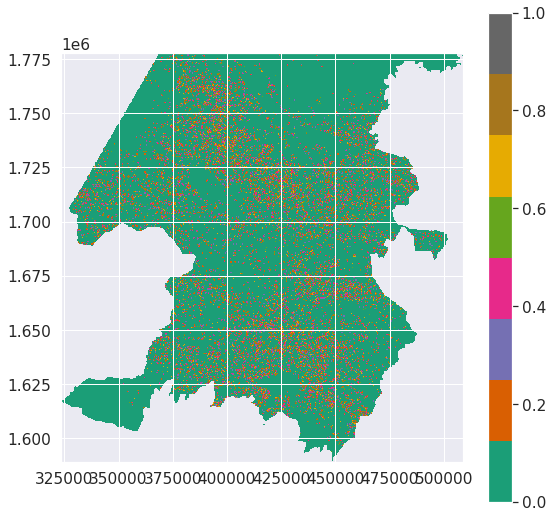

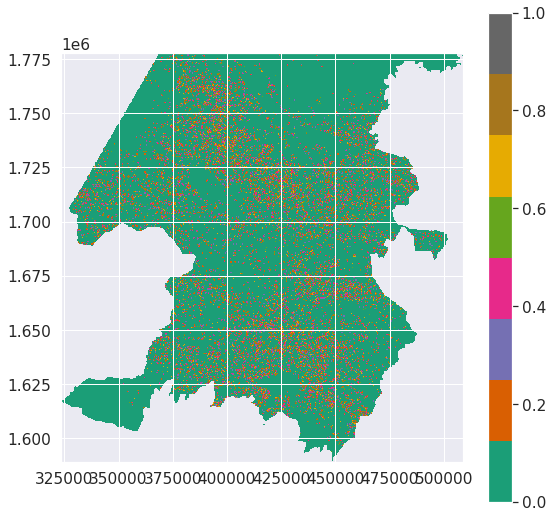

In [ ]:
fig, ax = plt.subplots(figsize=(9, 9))

result.iloc[0].cmap = "Dark2"
result.iloc[0].categorical = True
result.pred_raw_0.plot(ax=ax, legend=True)
plt.show()

In [ ]:
y_pred_svm = svc.predict(x_test)

y_svm_proba = svc.predict_proba(x_test)[::,1]

### Params default

In [ ]:
base_svm = svm.SVC(probability=True)
base_svm = Pipeline(
    [('scaling', StandardScaler()),
        ('classifier', base_svm)])


base_svm.fit(x_train, y_train)

Pipeline(steps=[('scaling', StandardScaler()),
                ('classifier', SVC(probability=True))])

In [ ]:
result = rasters.predict(estimator=base_svm, progress=True)

result_probs = rasters.predict_proba(estimator=base_svm, progress=True)

100%|█████████▉| 1368/1369 [05:25<00:00,  4.20it/s]


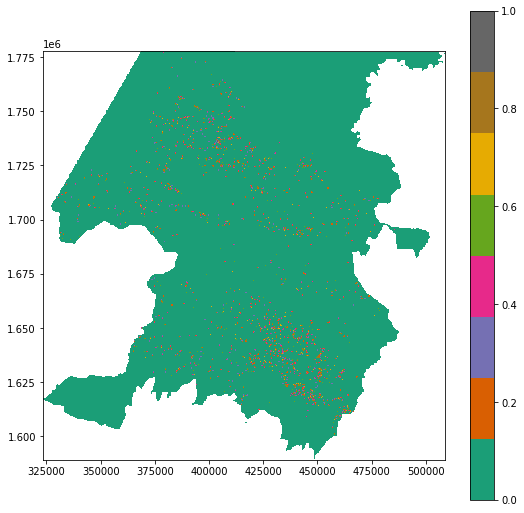

In [ ]:
fig, ax = plt.subplots(figsize=(9, 9))

result.iloc[0].cmap = "Dark2"
result.iloc[0].categorical = True
result.pred_raw_0.plot(ax=ax, legend=True)
plt.show()

In [ ]:
y_pred_svmb = base_svm.predict(x_test)

y_svmb_proba = base_svm.predict_proba(x_test)[::,1]

### Métricas

In [ ]:
print(classification_report(y_test, y_pred_svm,digits=5))

              precision    recall  f1-score   support

         0.0    0.90361   0.92348   0.91344      1137
         1.0    0.76923   0.72139   0.74454       402

    accuracy                        0.87070      1539
   macro avg    0.83642   0.82244   0.82899      1539
weighted avg    0.86851   0.87070   0.86932      1539



In [ ]:
print(classification_report(y_test, y_pred_svmb,digits=5))

              precision    recall  f1-score   support

         0.0    0.76751   0.99296   0.86580      1137
         1.0    0.88235   0.14925   0.25532       402

    accuracy                        0.77258      1539
   macro avg    0.82493   0.57111   0.56056      1539
weighted avg    0.79750   0.77258   0.70634      1539



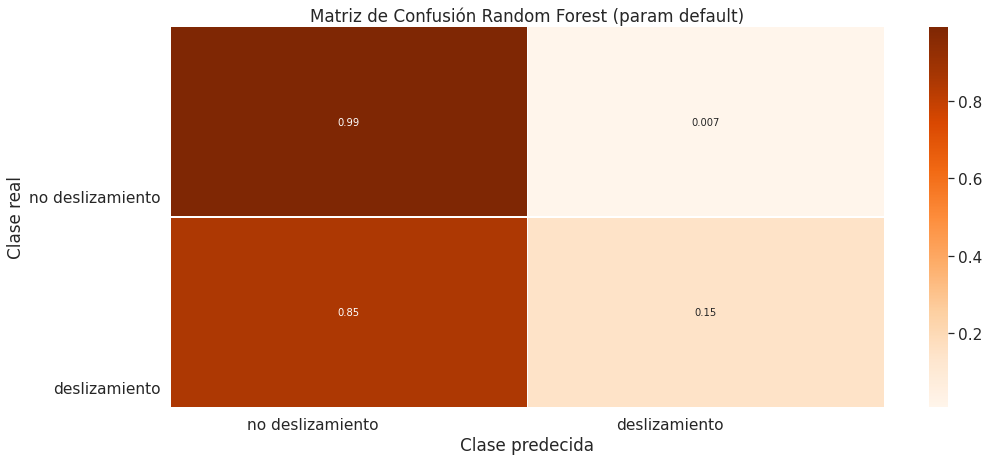

In [ ]:
matrix = confusion_matrix(y_test, y_pred_svmb)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:,np.newaxis]

plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Oranges, linewidths=0.2)

# Add labels to the plot
class_names = ['no deslizamiento','deslizamiento']
tick_marks = np.arange(len(class_names)) + 0.4
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Clase predecida')
plt.ylabel('Clase real')
plt.title('Matriz de Confusión Random Forest (param default)')
plt.show()

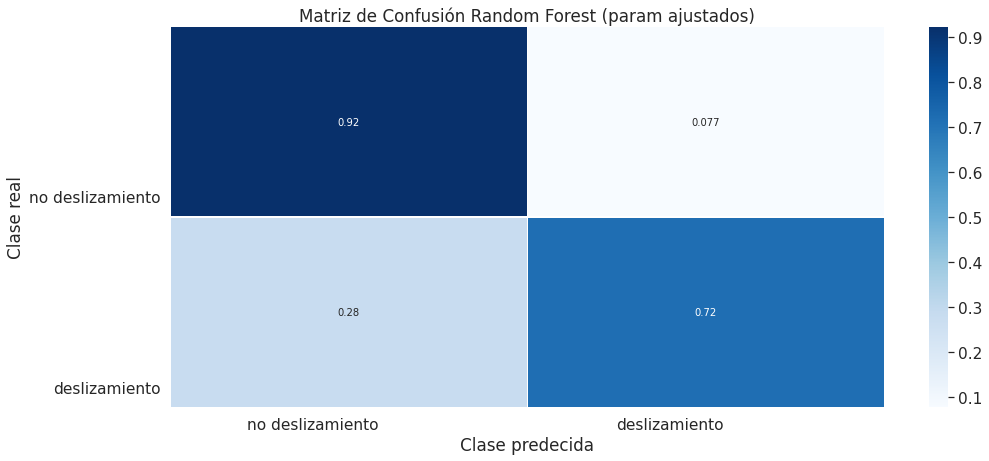

In [ ]:
matrix = confusion_matrix(y_test, y_pred_svm)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:,np.newaxis]

plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Blues, linewidths=0.2)

# Add labels to the plot
class_names = ['no deslizamiento','deslizamiento']
tick_marks = np.arange(len(class_names)) + 0.4
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Clase predecida')
plt.ylabel('Clase real')
plt.title('Matriz de Confusión Random Forest (param ajustados)')
plt.show()

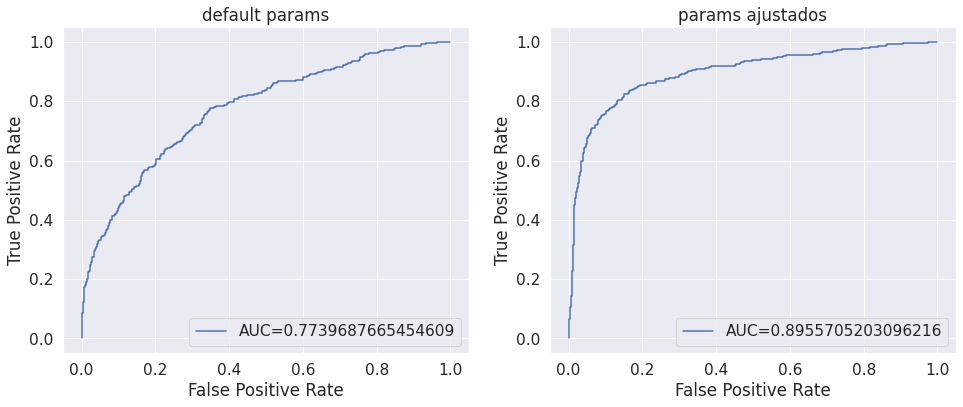

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_svmb_proba)

auc = roc_auc_score(y_test, y_svmb_proba)

#curva ROC

fig, axes = plt.subplots(nrows=1, ncols=2, figsize= (16,6))

axes[0].plot(fpr,tpr,label="AUC="+str(auc))
axes[0].set_title('default params')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_xlabel('False Positive Rate')
axes[0].legend(loc=4)

fpr, tpr, _ = roc_curve(y_test, y_svm_proba)

auc2 = roc_auc_score(y_test, y_svm_proba)

#curva ROC

axes[1].plot(fpr,tpr,label="AUC="+str(auc2))
axes[1].set_title('params ajustados')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_xlabel('False Positive Rate')
axes[1].legend(loc=4)
plt.show()

In [ ]:
base_scores = cross_validate(
    estimator=base_svm,
    X=x_test,
    y=y_test,
    scoring=['accuracy', 'precision', 'recall', 'f1'],
    cv=5,
    return_train_score=True
)

for i, item in base_scores.items():
    print(f'{i} media: {item.mean()}')

fit_time media: 0.8228183269500733
score_time media: 0.004380035400390625
test_accuracy media: 0.7615444815770549
train_accuracy media: 0.7694929156951903
test_precision media: 0.7336268478683339
train_precision media: 0.8280887975564978
test_recall media: 0.13441358024691358
train_recall media: 0.15049437897873494
test_f1 media: 0.2260010016456727
train_f1 media: 0.25292228275685613


In [ ]:
scores = cross_validate(
    estimator=svc,
    X=x_test,
    y=y_test,
    scoring=['accuracy', 'precision', 'recall', 'f1'],
    cv=5,
    return_train_score=True
)

for i, item in scores.items():
    print(f'{i} media: {item.mean()}')

fit_time media: 0.23448829650878905
score_time media: 0.004690361022949219
test_accuracy media: 0.8128643343627058
train_accuracy media: 0.9871666209501303
test_precision media: 0.6590426978129538
train_precision media: 0.9823907814187225
test_recall media: 0.5841666666666667
train_recall media: 0.9682881523190341
test_f1 media: 0.6179646886143597
train_f1 media: 0.9752454510560786


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


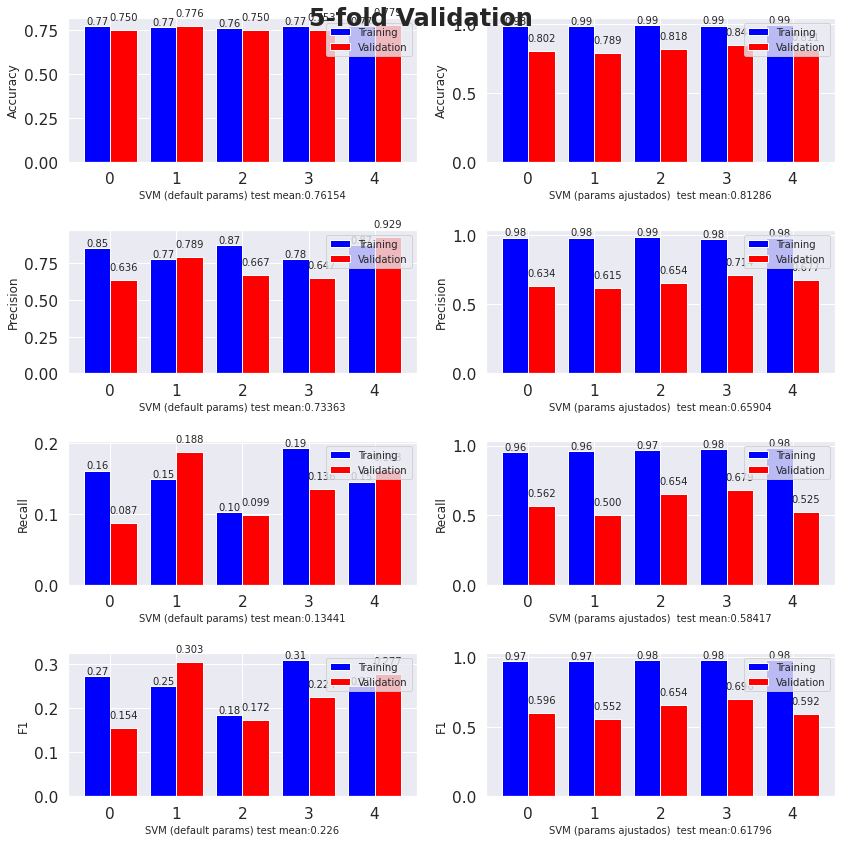

In [ ]:
figure, axes = plt.subplots(nrows=4, ncols=2, figsize=(12,12))

metrics = ['accuracy', 'precision','recall','f1']

figure.suptitle('5-fold Validation', fontsize=24, fontweight='bold')

for index, metric in enumerate(metrics):
    pivot = 0
    plot_result('SVM (default params) test mean:'+str(round(base_scores[f'test_{metric}'].mean(),5)),f'{metric.capitalize()}',base_scores[f'train_{metric}'],base_scores[f'test_{metric}'], axes[index,pivot])
    pivot+=1
    plot_result(f'SVM (params ajustados)  test mean:'+str(round(scores[f'test_{metric}'].mean(),5)),f'{metric.capitalize()}',scores[f'train_{metric}'],scores[f'test_{metric}'], axes[index,pivot])
figure.tight_layout()
plt.show()